$# Understand the Assets 

This notebooks breaks down the market from a data perspective, avoiding theoreical assumptions, simple looking to understand the correlations & variations across assets.

# Section 1. Read Data


Notes:
Command to write requirements file:
$$ conda list --export > requirements.txt$$

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('default')
from datetime import date, datetime
from tqdm import tqdm
import pickle

In [3]:
# ---- ETFs ----x
available_EFTs = pd.read_excel('../data/EFTs_from_JSE.xlsx')
tickers        = available_EFTs.Alpha.to_list()


print('ETF tickers:')
print('---------------------------------')
print(len(tickers), 'tickers available')
print()
print(str(tickers[1:5]) + '...')
print('---------------------------------')

ETF tickers:
---------------------------------
1021 tickers available

['GFI', 'INL', 'AVI', 'CAC']...
---------------------------------


In [4]:
# ---- easy equityies instruments ----x
easy_equities = pd.read_excel('../data/EasyEquitiesInstruments.xlsx')
tickers        = easy_equities.Ticker.to_list()

print('ETF tickers:')
print('---------------------------------')
print(len(tickers), 'tickers available')
print()
print(str(tickers[1:5]) + '...')
print('---------------------------------')

ETF tickers:
---------------------------------
718 tickers available

['DCCUS2', '4SI', 'ABSP', 'APF']...
---------------------------------


In [5]:
# ---- hyperparamters ----x
start  = '2000-01-01'
end    =  str(date.today())
print('Date Range:')
print('-----------------------')
print('Start date: ', start)
print('End date:   ', end)
print('-----------------------')

Date Range:
-----------------------
Start date:  2000-01-01
End date:    2021-03-30
-----------------------


In [6]:
path = '../data/easy_equities_ETF.pkl'

with open(path, 'rb') as f:
    data = pickle.load(f)

In [7]:
print('dimensions:', data.shape)
print('-----------------------')
print(data.head())

dimensions: (1247148, 8)
-----------------------
         Date Symbols   Adj Close        Close         High          Low  \
ID                                                                         
0  2000-01-04  ADI.JO    5.343401    16.000000    21.000000    16.000000   
1  2000-01-04  ADR.JO  929.124451  2395.000000  2500.000000  2395.000000   
2  2000-01-04  ADH.JO   63.023960   111.255302   117.110802   111.255302   
3  2000-01-04  AFE.JO  556.016541  1258.670044  1283.540039  1258.670044   
4  2000-01-04  ADW.JO  421.445007   421.445007   526.806030   421.445007   

           Open    Volume  
ID                         
0     21.000000       0.0  
1   2395.000000    1800.0  
2    117.110802   10963.0  
3   1283.540039  565983.0  
4    526.806030       0.0  


## Compute Summary Stats

Summary statistics need to computed over a date range, thus we write a function to readily compute the summary stats (return, volatility, etc) over a given range.

## Select Parameters

To ***save on superfluous computation***. To do so, filter as much as possible before performing computations.

## Filter:
- Assets
- Dates
- Sectors

In [8]:
# --- Original tickers ---x
data['Ticker']    = [s.replace('.JO', '') for s in data.Symbols]
available_tickers = data['Ticker'].unique()

In [9]:
# --- Compute Summary Stats ---x
def summary_stats(data=data, start=start, end=end, tickers=available_tickers, 
    available_EFTs=available_EFTs, easy_equities=easy_equities):

    for u in tqdm(tickers):
        sub = data.loc[data.Ticker == u,]

        # ---- closest dates ----x
        from_start  = abs(sub.Date - datetime.strptime(start, '%Y-%m-%d'))
        from_end    = abs(sub.Date - datetime.strptime(end, '%Y-%m-%d'))
        start_index = np.argmin(from_start)
        end_index   = np.argmin(from_end)

        # ---- filter over range ----x
        sub = sub.iloc[start_index:end_index+1, ]

        # ---- extract key values ----x
        mn = sub.loc[sub.Date == sub.Date.min(), 'Close'].values[0]
        mx = sub.loc[sub.Date == sub.Date.max(), 'Close'].values[0]

        # ---- summary stats ----x
        tot_ret = (mx-mn)/mn
        std_dev = np.std(sub['Close'])
        av_vol  = np.mean(sub['Volume'])
        
        # --- create df ---x
        d  = {'Symbol': u, 'start_date': sub.Date.min(), 'end_date': sub.Date.max(), 
        'total_return':tot_ret, 'asset_std': std_dev}
        df = pd.DataFrame(data=d, index=[0])

        if 'sum_stats' not in locals(): sum_stats = df
        else: sum_stats = sum_stats.append(df, ignore_index=True)

        if 'filtered_data' not in locals(): filtered_data = sub
        else: filtered_data = filtered_data.append(sub, ignore_index=True)

    
    # --- join data ---x
    # --- extract data ---x
    sum_stats = sum_stats
    sum_stats['Ticker'] = sum_stats.Symbol

    # --- join data ---x
    available_EFTs['Ticker'] = available_EFTs['Alpha']
    df = sum_stats.merge(easy_equities, on=['Ticker', 'Ticker'], how='left')
    df = df.merge(available_EFTs, on=['Ticker', 'Ticker'], how='left')

    # --- prune ---x
    df = df[['Symbol', 'start_date', 'end_date', 'total_return', 'asset_std',
        'Ticker', 'Instrument Name', 'Exchange_x',
        'Exchange Opening Time GMT', 'Exchange Closing Time GMT', 'Tick Size',
        'Overall Maximum Risk Quantity', 'Minimum Risk Quantity', 'Shortable',
        'ISIN Code', 'Account Type', 'StatisticDate', 'Alpha',
        'LongName', 'ListingDate', 'Exchange_y', 'Market', 'Board', 'InsStatus',
        'ICBSubSectorCode', 'ICBSubSectorShortName', 'ICBSubSectorLongName',
        'ICBSectorCode', 'ICBSectorShortName', 'ICBSectorLongName',
        'ICBSuperSectorCode', 'ICBSuperSectorShortName',
        'ICBSuperSectorLongName', 'ICBIndustryCode', 'ICBIndustryShortName',
        'ICBIndustryLongName', 'ClosingPrice (ZAC)']]
    # df.info()

    # --- results ---x
    results = {
        'sum_stats':       sum_stats,
        'joint_sum_stats': df,
        'filtered_data':   filtered_data
    }
    return(results)


In [10]:
results = summary_stats()

100%|██████████| 379/379 [01:36<00:00,  3.94it/s]


In [11]:
results['joint_sum_stats'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 0 to 378
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Symbol                         379 non-null    object        
 1   start_date                     379 non-null    datetime64[ns]
 2   end_date                       379 non-null    datetime64[ns]
 3   total_return                   379 non-null    float64       
 4   asset_std                      379 non-null    float64       
 5   Ticker                         379 non-null    object        
 6   Instrument Name                379 non-null    object        
 7   Exchange_x                     379 non-null    object        
 8   Exchange Opening Time GMT      379 non-null    object        
 9   Exchange Closing Time GMT      379 non-null    object        
 10  Tick Size                      379 non-null    float64       
 11  Overall Maximum Ris

In [12]:
results['filtered_data'][['Ticker', 'Close', 'Volume']].groupby('Ticker').agg(['min', 'max', 'mean'])

Close                         Volume                          
             min       max          mean    min         max          mean
Ticker                                                                   
4SI        13.00     285.0     57.271462    0.0   5003000.0  1.655122e+05
ABSP    46400.00  100000.0  80280.962403    0.0    151508.0  3.866846e+03
ACG         4.23    1850.0    708.878840    0.0  12935575.0  2.183759e+05
ACL         9.00   26100.0   4326.932760    0.0  32219374.0  8.308468e+05
ACS       225.00    1100.0    751.414330    0.0    500000.0  4.170141e+03
...          ...       ...           ...    ...         ...           ...
WKF         1.08     245.0     97.054473    0.0   7300611.0  3.185662e+04
WSL        49.00     300.0    126.911371    0.0  18899890.0  1.881194e+05
YRK         1.05    4000.0    513.390773    0.0  12780419.0  6.352840e+04
ZED       134.00     925.0    403.176971    0.0  69908959.0  1.168713e+06
ZPLP     3770.00   10000.0   6204.653743    0.0  35640617.0  1.574269e+05

[379 rows x 6 columns]

In [13]:
# df.head()
# results['joint_sum_stats'].info()

lt = ['ICBSectorCode', 'ICBSectorShortName', 'ICBSectorLongName', 'ICBSuperSectorCode', 
    'ICBSuperSectorShortName','ICBSuperSectorLongName', 'ICBIndustryCode', 'ICBIndustryShortName', 'ICBIndustryLongName']
for l in tqdm(lt):
    print(l, ': ', len(results['joint_sum_stats'][l].unique()))

100%|██████████| 9/9 [00:00<00:00, 4862.65it/s]ICBSectorCode :  40
ICBSectorShortName :  40
ICBSectorLongName :  40
ICBSuperSectorCode :  22
ICBSuperSectorShortName :  22
ICBSuperSectorLongName :  22
ICBIndustryCode :  11
ICBIndustryShortName :  11
ICBIndustryLongName :  11



# Visualize

In [14]:
import plotly.express as px

# ---- impute ----x
df = results['joint_sum_stats']
df['ICBIndustryLongName'] = df['ICBIndustryLongName'].fillna('Other')

fig = px.scatter(df, 
        x='Symbol', size='asset_std', y='total_return', color='ICBIndustryLongName',
        title='Asset Diagnostics',
        width=1000, height=600,
        labels={'total_return': 'Return %', 'Symbol':'Ticker', 'asset_std': 'Standard Deviation'},
        hover_name='Symbol', log_y=True, log_x=False)

fig.update_layout(
    font_family="Rockwell",
    legend=None, 
)
fig.show()

In [15]:
# ---- impute ----x
df = results['joint_sum_stats']
df['ICBIndustryLongName'] = df['ICBIndustryLongName'].fillna('Other')


fig = px.box(df, y='total_return', x='ICBIndustryLongName', color='ICBIndustryLongName', 
    width=1000, height=600)
fig.update_layout(yaxis=dict(range=[-20,100]))
fig.show()

In [16]:

# ---- satrix assets ----x
dt  = results['filtered_data'].loc[['STX' in s for s in results['filtered_data']['Symbols']],]
fig = px.line(dt, x='Date', y='Close', color='Symbols', width=1000, height=500,
        title='Asset Prices')
fig.show()

In [17]:
# dt.groupby() # .Close.shift(-1)



# --- wide format ---x
dt_wide = dt.pivot_table(index=['Date'], 
            columns='Symbols', 
            values='Close')

# ---- lag ----x
dt_wide_lag = dt.pivot_table(index=['Date'], 
                columns='Symbols', 
                values='Close').shift(-1)

# ---- compute daily return ----x
daily_return = (dt_wide - dt_wide_lag) /dt_wide_lag        

# ---- convert to long format ----x
daily_return['date'] = daily_return.index
daily_return_long_format = daily_return.melt('date', var_name='asset', value_name='daily_return')

In [18]:
fig = px.line(daily_return_long_format, x='date', y='daily_return', color='asset', width=1000, height=500,
        title='Asset daily returns')
fig.show()

In [19]:
import plotly.figure_factory as ff

colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
# fig = ff.create_distplot(daily_return_long_format, 'asset',
#                          bin_size=.2, show_rug=False)

fig = px.histogram(
        daily_return_long_format.loc[daily_return_long_format['daily_return'] < 0.2, ].loc[
            daily_return_long_format['daily_return'] > -0.2, ], 
            x='daily_return',color="asset", 
        nbins=250
        # marginal=marginal, range_x=[-5, 60],
        # hover_data='asset'
        )



fig.show()

# Correlation Plots

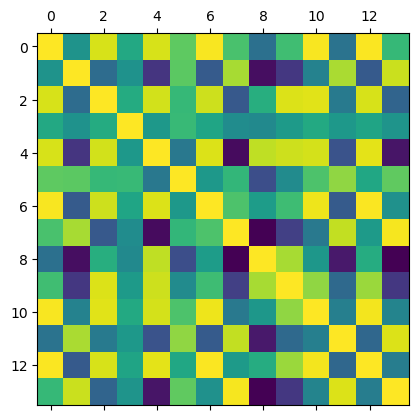

In [20]:
# --- wide format ---x
dt_wide = dt.pivot_table(index=['Date'], 
            columns='Symbols', 
            values='Close')

fig = px.imshow(dt_wide.corr(), color_continuous_scale='RdBu_r')
fig.show()

plt.matshow(dt_wide.corr())
plt.show()

In [21]:
corr = dt_wide.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

NameError: name 'sns' is not defined

In [84]:
# ----- Cluster !!!!! -----x

from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as spc

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [1]:
corr.columns

NameError: name 'corr' is not defined

In [ ]:
import pandas as pd
import scipy.cluster.hierarchy as spc





In [28]:
sub['Close'][sub['Close'] > 10000]

Series([], Name: Close, dtype: float64)

In [71]:
sub = daily_return_long_format.loc[daily_return_long_format.asset == 'STX500.JO',]
ind = np.where(sub['daily_return'] > 90)[0][0]
dts = sub.iloc[ind-1:ind+2, ][['date']]

sub = results['filtered_data'].loc[results['filtered_data'].Symbols == 'STX500.JO',]
sub.Date == dts

ipykernel_launcher:6: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



date  1222991  1222992  1222993  1222994  1222995  1222996  1222997  \
6202  False    False    False    False    False    False    False    False   
6203  False    False    False    False    False    False    False    False   
6204  False    False    False    False    False    False    False    False   

      1222998  1222999  ...  1223902  1223903  1223904  1223905  1223906  \
6202    False    False  ...    False    False    False    False    False   
6203    False    False  ...    False    False    False    False    False   
6204    False    False  ...    False    False    False    False    False   

      1223907  1223908  1223909  1223910  1223911  
6202    False    False    False    False    False  
6203    False    False    False    False    False  
6204    False    False    False    False    False  

[3 rows x 922 columns]

In [ ]:
# libraries
import seaborn as sns
import matplotlib.pyplot as plt

# load data set
df = sns.load_dataset('iris')

# Basic correlogram
sns.pairplot(df)
plt.show()

In [32]:
import plotly.express as px

fig = px.scatter(sum_stats, 
        x='Symbol', size='asset_std', y='total_return', color='Symbol',
        title='Asset Diagnostics',
        width=1000, height=600,
        labels={'total_return': 'Return %', 'Symbol':'Ticker'},
        hover_name='Symbol', log_y=True, log_x=False)

fig.update_layout(
    font_family="Rockwell",
    legend=None, #dict(title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center")
)
fig.show()

In [49]:
import plotly.express as px

fig = px.scatter(sum_stats, 
        x='asset_std', size='asset_std', y='total_return', color='Symbol',
        title='Asset Diagnostics',
        width=1000, height=600,
        labels={'total_return': 'Return %', 'Symbol':'Ticker', 'asset_std': 'Standard Deviation'},
        hover_name='Symbol', log_y=True, log_x=False)

fig.update_layout(
    font_family="Rockwell",
    legend=None, 
)
fig.show()

0             Technology
1            Industrials
2      Consumer Services
3        Basic Materials
4             Financials
             ...        
374          Industrials
375           Additional
376           Additional
377           Additional
378           Additional
Name: ICBIndustryLongName, Length: 379, dtype: object

In [ ]:
meta = funds[['Alpha', 'Asset_age', 'volume', 'return']]
meta = meta.loc[meta.volume.notnull(), ]

# scale 
meta['volume_log'] = np.log(meta['volume'])
meta = meta.loc[-meta['volume_log'].isin([-np.inf, np.inf]), ]



In [ ]:
fig = px.scatter(meta, x='Asset_age', size='volume_log', 
                 y='return', color='Alpha',
           hover_name='Alpha', log_y=False, log_x=False)

fig.show()